In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, re
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from xgboost import XGBRegressor

from scipy import stats
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression

In [2]:
hp_train_data = pd.read_csv('data/train.csv')
hp_test_data = pd.read_csv('data/test.csv')

## Training data pre-processing

In [3]:
hp_train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
hp_train_data.shape

(1460, 81)

In [5]:
hp_train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Correlation Matrix (heat map)

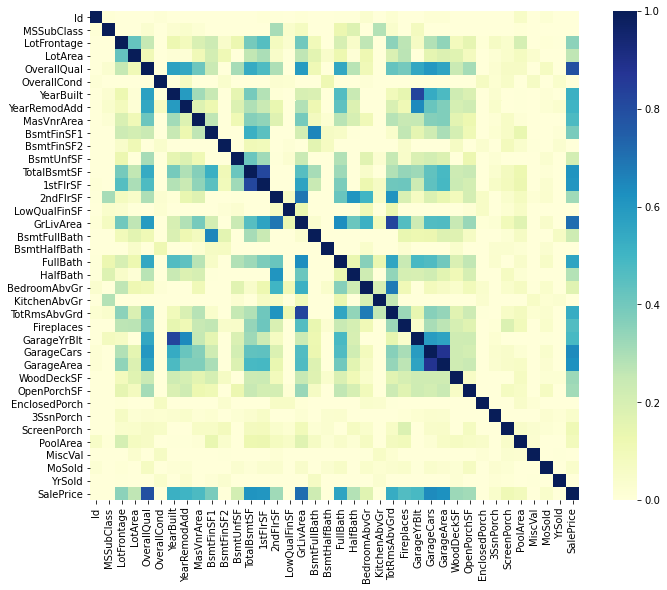

In [6]:
corr_mat = hp_train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmin=0, vmax=1, square=True, cmap='YlGnBu', ax=ax)
plt.show()

In [7]:
""" Analysis Significant Output (SalePrice)  (Train data only)  """
#SalePrice is the output for later prediction model
#It is important that need to check its properties. Ex: min > 0 , mean no abnormal price happen
hp_train_data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

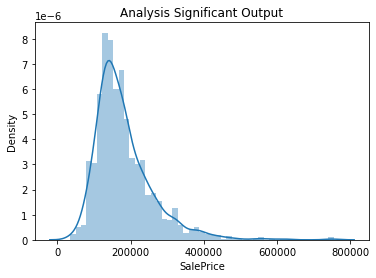

In [8]:
sns.distplot(hp_train_data['SalePrice']).set_title('Analysis Significant Output')
plt.show()

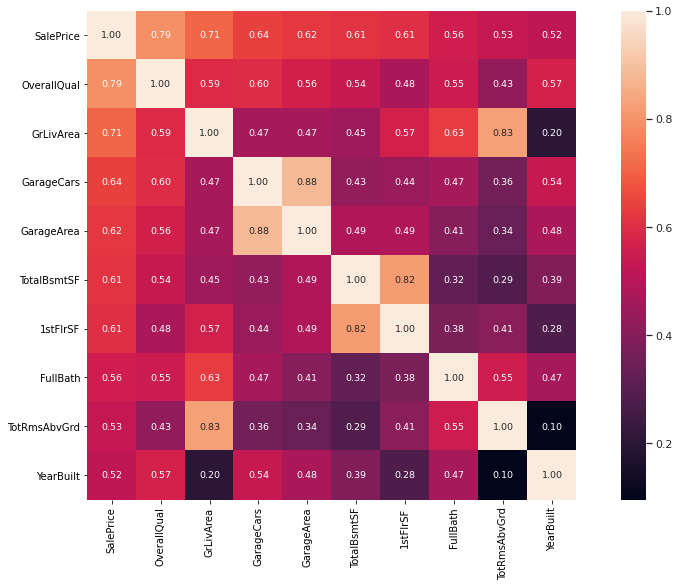

In [9]:
""" Analysis The Relationship Btw Output(SalePrice) and Correlated Variables  (Train data only)   """
#Get top n largest value order by SalePrice,then get the dataframe index because its  position changed.
cols = corr_mat.nlargest(10, 'SalePrice').index
corr_mat2 = hp_train_data[cols].corr()
plt.subplots(figsize=(16,9))
sns.set(font_scale=1)
sns.heatmap(corr_mat2, annot=True, annot_kws={'size': 9.5}, square=True, fmt='.2f')
plt.show()

### Pair plots

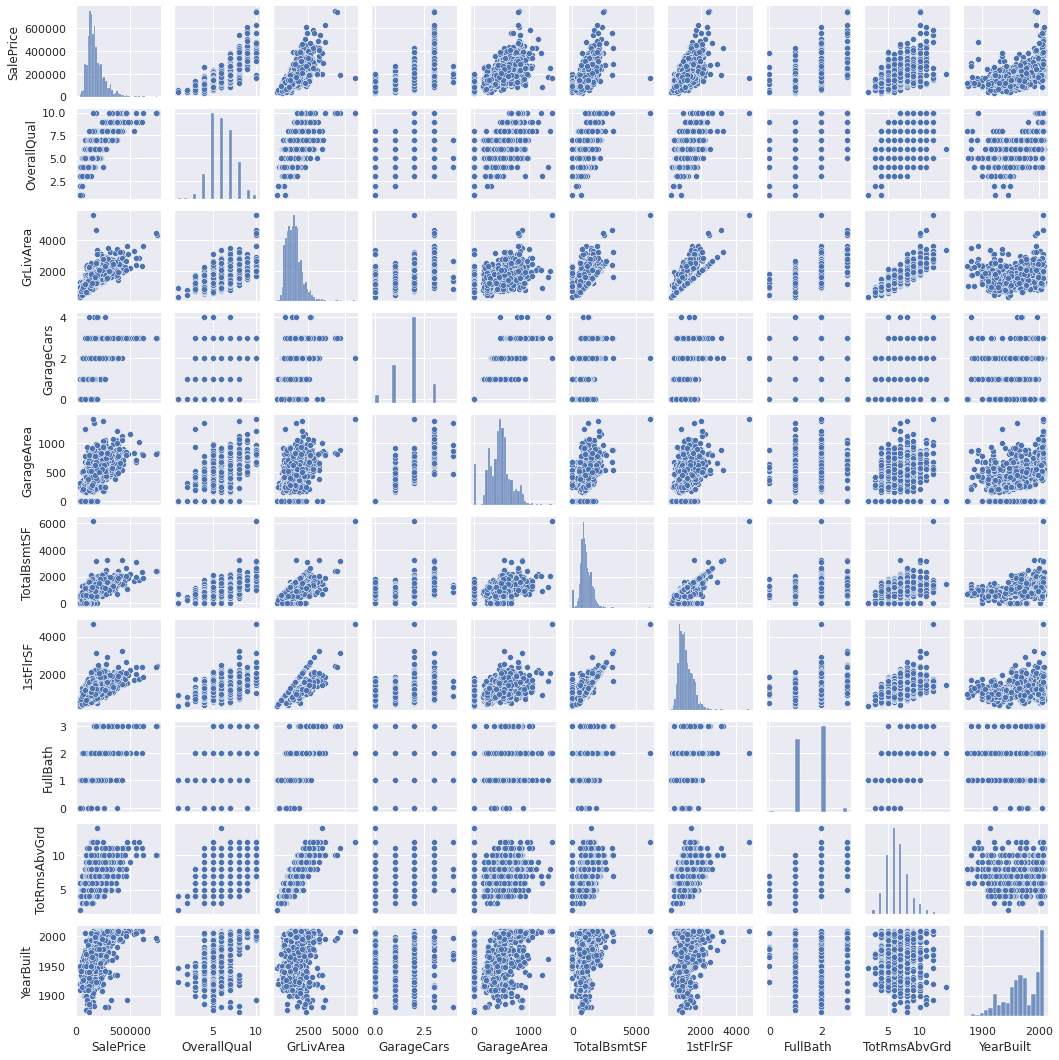

In [10]:
sns.set()
sns.pairplot(hp_train_data[cols], size=1.5)
plt.show()

## Feature Engineering

### Remove Unwanted Features

In [11]:
Rem_cols_train = []
corr_mat_reg = hp_train_data.corr()
# keep value > 0.2 else become NaN
Filtered_Corr = corr_mat_reg[corr_mat_reg > 0.2]

Filtered_Corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSSubClass,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,NaN,NaN,1.000000,0.426095,0.251646,NaN,NaN,NaN,NaN,0.233633,...,NaN,NaN,NaN,NaN,NaN,0.206167,NaN,NaN,NaN,0.351799
LotArea,NaN,NaN,0.426095,1.000000,NaN,NaN,NaN,NaN,NaN,0.214103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263843
OverallQual,NaN,NaN,0.251646,NaN,1.000000,NaN,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.790982
OverallCond,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearBuilt,NaN,NaN,NaN,NaN,0.572323,NaN,1.000000,0.592855,0.315707,0.249503,...,0.224880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.522897
YearRemodAdd,NaN,NaN,NaN,NaN,0.550684,NaN,0.592855,1.000000,NaN,NaN,...,0.205726,0.226298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.507101
MasVnrArea,NaN,NaN,NaN,NaN,0.411876,NaN,0.315707,NaN,1.000000,0.264736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.477493
BsmtFinSF1,NaN,NaN,0.233633,0.214103,0.239666,NaN,0.249503,NaN,0.264736,1.000000,...,0.204306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.386420


In [12]:
for fc in Filtered_Corr.columns:
    # If equal 1, means only 1 value present and others are Nan, then this cols need to be removed
    if Filtered_Corr[fc].value_counts().sum() <= 1:
        Rem_cols_train.append(fc)
Rem_cols_train # these are columns need to remove

['Id',
 'OverallCond',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'MoSold',
 'YrSold']

In [13]:
# removing unwanted columns
hp_train_data.drop(Rem_cols_train, axis=1, inplace=True)

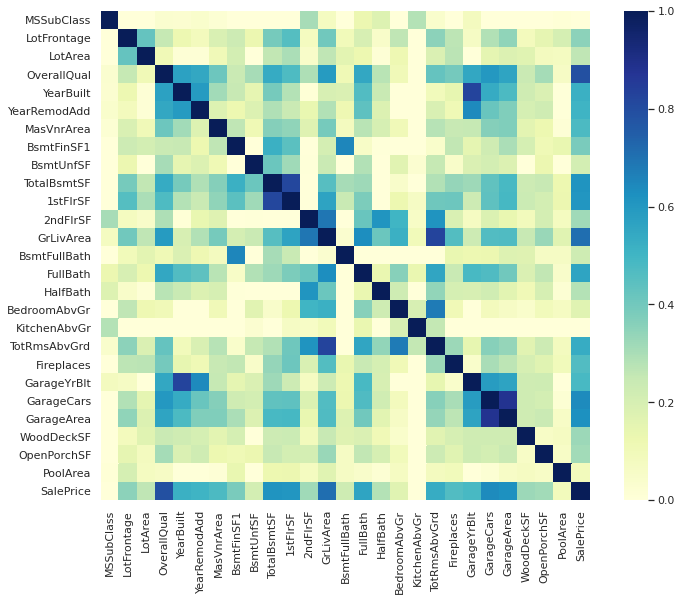

In [14]:
# show the heatmap
corrmat_rev = hp_train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_rev, vmin=0, vmax=1, square=True, cmap='YlGnBu',ax=ax)
plt.show()

#### Display Missing Data

In [15]:
total = hp_train_data.isnull().sum().sort_values(ascending=False)
total

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
HeatingQC           0
Heating             0
TotalBsmtSF         0
SaleCondition       0
MSSubClass          0
Length: 70, dtype: int64

In [16]:
percent = (hp_train_data.isnull().sum()/hp_train_data.shape[0]).sort_values(ascending=False)
percent

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
FireplaceQu      0.472603
                   ...   
HeatingQC        0.000000
Heating          0.000000
TotalBsmtSF      0.000000
SaleCondition    0.000000
MSSubClass       0.000000
Length: 70, dtype: float64

In [17]:
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percentage'])
missing_data.head(20)

,total,percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageFinish,81,0.055479
GarageType,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479


#### Imputation for missing data

In [18]:
#After examine the missing data, delete all the features except that with one miss data
Miss_cols = (missing_data[missing_data['total']>1]).index
hp_train_data = hp_train_data.drop(Miss_cols, axis=1)

In [19]:
# Fill in NaN with common info in specific columns
ComInfo_Elec = hp_train_data['Electrical'].value_counts().idxmax()
ComInfo_Elec

'SBrkr'

In [20]:
#df[df['column name'].isna()]
hp_train_data[hp_train_data['Electrical'].isna()]['Electrical']

1379    NaN
Name: Electrical, dtype: object

In [21]:
hp_train_data['Electrical'].fillna(ComInfo_Elec, inplace=True)

In [22]:
hp_train_data.loc[1370:1390]['Electrical']

1370    SBrkr
1371    SBrkr
1372    SBrkr
1373    SBrkr
1374    SBrkr
1375    SBrkr
1376    SBrkr
1377    SBrkr
1378    SBrkr
1379    SBrkr
1380    FuseF
1381    SBrkr
1382    SBrkr
1383    SBrkr
1384    SBrkr
1385    SBrkr
1386    SBrkr
1387    SBrkr
1388    SBrkr
1389    SBrkr
1390    SBrkr
Name: Electrical, dtype: object

In [23]:
hp_train_data['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

In [24]:
#just checking that there's no missing data
hp_train_data.isnull().sum().max()

0

In [25]:
# concatenate the removed features cols
Mc_list = [mc for mc in Miss_cols]
Rem_cols_train = Rem_cols_train + Mc_list

Rem_cols_train

['Id',
 'OverallCond',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'MoSold',
 'YrSold',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'LotFrontage',
 'GarageFinish',
 'GarageType',
 'GarageCond',
 'GarageQual',
 'GarageYrBlt',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond',
 'MasVnrArea',
 'MasVnrType']

In [26]:
""" Create the new feature """
# we will change the year to time according to present time
# if the house built in 1940 then we change that to 79 years of old
Yrcols = ['YearBuilt', 'YearRemodAdd']
hp_train_data[Yrcols[1]].unique().max()

2010

In [27]:
Year = 2019
hp_tempData = Year - hp_train_data[Yrcols]
hp_tempData

,YearBuilt,YearRemodAdd
0,16,16
1,43,43
2,18,17
3,104,49
4,19,19
...,...,...
1455,20,19
1456,41,31
1457,78,13
1458,69,23


In [28]:
# change the column name
hp_tempData.columns = ['YearBuilt_Reg', 'YearRemodAdd_Reg']
hp_tempData

,YearBuilt_Reg,YearRemodAdd_Reg
0,16,16
1,43,43
2,18,17
3,104,49
4,19,19
...,...,...
1455,20,19
1456,41,31
1457,78,13
1458,69,23


In [29]:
hp_train_data = pd.concat([hp_train_data, hp_tempData], axis=1)
hp_train_data = hp_train_data.drop(Yrcols, axis=1)

### Label encoding

In [30]:
# Label Encoding the ordinal variable [String ---> number]
lbl_encode_train = ['LotShape','LandContour','LandSlope'
                    ,'ExterQual','ExterCond','HeatingQC'
                    ,'KitchenQual','Functional','PavedDrive']
hp_train_data[lbl_encode_train]

,LotShape,LandContour,LandSlope,ExterQual,ExterCond,HeatingQC,KitchenQual,Functional,PavedDrive
0,Reg,Lvl,Gtl,Gd,TA,Ex,Gd,Typ,Y
1,Reg,Lvl,Gtl,TA,TA,Ex,TA,Typ,Y
2,IR1,Lvl,Gtl,Gd,TA,Ex,Gd,Typ,Y
3,IR1,Lvl,Gtl,TA,TA,Gd,Gd,Typ,Y
4,IR1,Lvl,Gtl,Gd,TA,Ex,Gd,Typ,Y
...,...,...,...,...,...,...,...,...,...
1455,Reg,Lvl,Gtl,TA,TA,Ex,TA,Typ,Y
1456,Reg,Lvl,Gtl,TA,TA,TA,TA,Min1,Y
1457,Reg,Lvl,Gtl,Ex,Gd,Ex,Gd,Typ,Y
1458,Reg,Lvl,Gtl,TA,TA,Gd,Gd,Typ,Y


In [31]:
# hp_train_data[lbl_encode_train[0]].unique()

In [32]:
# numeric_col = hp_train_data._get_numeric_data().columns
# cat_col = list(set(hp_train_data.columns) - set(numeric_col))
# cat_col

In [33]:
for lbl_c in lbl_encode_train:
    hp_train_data[lbl_c], _ = pd.factorize(hp_train_data[lbl_c])

In [34]:
hp_train_data[lbl_encode_train]

,LotShape,LandContour,LandSlope,ExterQual,ExterCond,HeatingQC,KitchenQual,Functional,PavedDrive
0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,1,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,1,0,0
1456,0,0,0,1,0,2,1,1,0
1457,0,0,0,2,1,0,0,0,0
1458,0,0,0,1,0,1,0,0,0


### Analyse Outliers

In [35]:
# Train data only
#----Bivariate analysis----
#By refering pairplot above, 'GrLivArea' and 'TotalBsmtSF' will be check with 'SalePrice'
#bivariate analysis saleprice - grlivarea
def bivrt_df_scatter(X, y, data=None, title=None, xlabel=None, ylabel=None):
    if isinstance(data, pd.DataFrame):
        df = pd.concat([data[X], data[y]], axis=1)
        df.plot.scatter(x=X, y=y, title=title)
    else:
        plt.scatter(x=X, y=y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.show();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


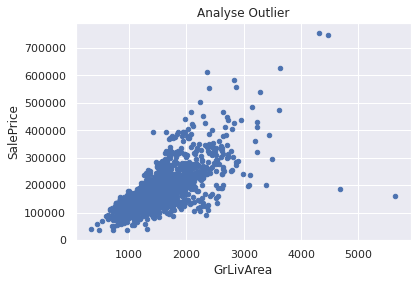

In [36]:
bivrt_df_scatter('GrLivArea', 'SalePrice', hp_train_data, title='Analyse Outlier') 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


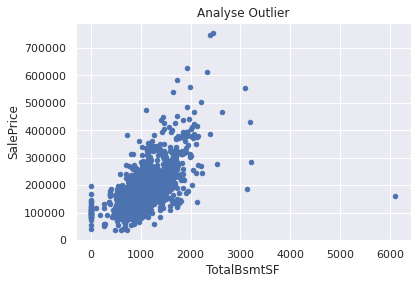

In [37]:
bivrt_df_scatter('TotalBsmtSF', 'SalePrice', hp_train_data, title='Analyse Outlier')

In [38]:
""" Solving Outliers (Train data only) """
#deleting points that locate at abnormal positions by observing the scatter graph
#SalePrice - GrLivArea
hp_train_data.sort_values(by='GrLivArea', ascending=False)[['GrLivArea','TotalBsmtSF', 'SalePrice']][:2]

,GrLivArea,TotalBsmtSF,SalePrice
1298,5642,6110,160000
523,4676,3138,184750


In [39]:
hp_train_data = hp_train_data.drop(hp_train_data[hp_train_data.index == 1298].index)
hp_train_data = hp_train_data.drop(hp_train_data[hp_train_data.index == 523].index)

In [40]:
# hp_train_data.sort_values(by='TotalBsmtSF', ascending=False)[['TotalBsmtSF','SalePrice']]


### Solving Normality To Prevent Heteroscedasticity

In [41]:
""" Solving Normality To Prevent Heteroscedasticity"""
def NormSolver(hp_data):

    """----GrLivArea----"""
    #Before
    #histogram and normal probability plot
    sns.distplot(hp_data['GrLivArea'], fit=stats.norm,ax= ax[0][2],color ='m').set_title('Before') # fit=stats.norm: Insert expected bell shape for the data
    stats.probplot(hp_data['GrLivArea'], plot=ax[0][3])
    ax[0][3].get_lines()[0].set_markerfacecolor('m')
    #skewness and kurtosis
    gla_bf_skew = hp_data['GrLivArea'].skew()
    gla_bf_kurt = hp_data['GrLivArea'].kurt()
    print('---GrLivArea (Before)---')
    print("Skewness: %f" % gla_bf_skew)
    print("Kurtosis: %f" % gla_bf_kurt)
    
    #After
    #applying log transformation
    hp_data['GrLivArea'] = np.log(hp_data['GrLivArea'])
    #histogram and normal probability plot
    sns.distplot(hp_data['GrLivArea'], fit=stats.norm,ax= ax[1][2],color ='m').set_title('After')
    stats.probplot(hp_data['GrLivArea'], plot=ax[1][3])
    ax[1][3].get_lines()[0].set_markerfacecolor('m')
    #skewness and kurtosis
    gla_af_skew = hp_data['GrLivArea'].skew()
    gla_af_kurt = hp_data['GrLivArea'].kurt()
    print('---GrLivArea (After)---')
    print("Skewness: %f" % gla_af_skew)
    print("Kurtosis: %f" % gla_af_kurt)
    
    """----TotalBsmtSF----"""
    #Before
    #histogram and normal probability plot
    sns.distplot(hp_data['TotalBsmtSF'], fit=stats.norm,ax= ax[0][4],color ='g').set_title('Before')
    stats.probplot(hp_data['TotalBsmtSF'], plot=ax[0][5])
    ax[0][5].get_lines()[0].set_markerfacecolor('g')
    #skewness and kurtosis
    tbs_bf_skew = hp_data['TotalBsmtSF'].skew()
    tbs_bf_kurt = hp_data['TotalBsmtSF'].kurt()
    print('---TotalBsmtSF (Before)---')
    print("Skewness: %f" % tbs_bf_skew)
    print("Kurtosis: %f" % tbs_bf_kurt)
    
    #After
    #Log transformation : log tranf -> 0 , get -inf
    hp_data['TotalBsmtSF'] = np.log(hp_data['TotalBsmtSF'])
    #Replace -inf or inf to 0 ; inplace = True : Overwrite to hp_data
    hp_data['TotalBsmtSF'].replace([np.inf, -np.inf], 0, inplace = True)
    #histogram and normal probability plot without 0
    sns.distplot(hp_data[hp_data['TotalBsmtSF']>0]['TotalBsmtSF'], fit=stats.norm,ax=ax[1][4],color ='g').set_title('After')
    stats.probplot(hp_data[hp_data['TotalBsmtSF']>0]['TotalBsmtSF'], plot=ax[1][5])
    ax[1][5].get_lines()[0].set_markerfacecolor('g')
    #skewness and kurtosis
    tbs_af_skew = hp_data['TotalBsmtSF'].skew()
    tbs_af_kurt = hp_data['TotalBsmtSF'].kurt()
    print('---TotalBsmtSF (After)---')
    print("Skewness: %f" % tbs_af_skew)
    print("Kurtosis: %f" % tbs_af_kurt)
    
    skew_kurt_bf = {'gla_bf_skew': gla_bf_skew ,'gla_bf_kurt': gla_bf_kurt,
                    'tbs_bf_skew': tbs_bf_skew ,'tbs_bf_kurt': tbs_bf_kurt,               
                    }
    
    skew_kurt_af = {'gla_af_skew': gla_af_skew ,'gla_af_kurt': gla_af_kurt,
                    'tbs_af_skew': tbs_af_skew ,'tbs_af_kurt': tbs_af_kurt                 
                    }
    
    return [hp_data,skew_kurt_bf,skew_kurt_af]

---SalePrice (Before)----
Skewness: 1.8812964895244009
Kurtosis: 6.523066888485879
---SalePrice (After)---
Skewness: 0.121568
Kurtosis: 0.804764
---GrLivArea (Before)---
Skewness: 1.010992
Kurtosis: 2.063463
---GrLivArea (After)---
Skewness: -0.071819
Kurtosis: 0.096331
---TotalBsmtSF (Before)---
Skewness: 0.511703
Kurtosis: 1.770105
---TotalBsmtSF (After)---
Skewness: -5.170369
Kurtosis: 27.813993


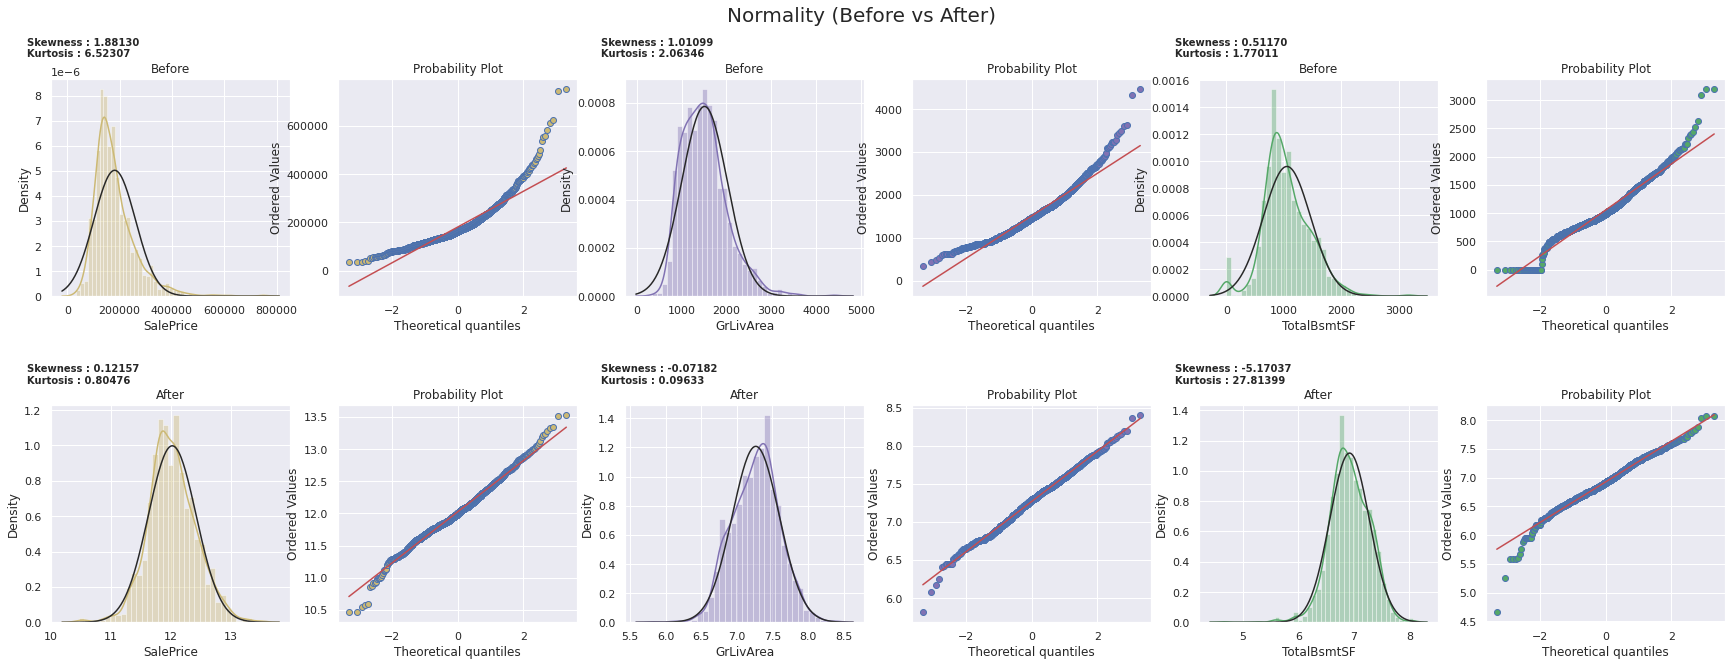

In [42]:
fig, ax = plt.subplots(figsize=(30, 10), nrows=2, ncols=6)
plt.subplots_adjust(hspace=0.5)
#-----SalePrice---------
# Before
# histogram and normal probability plot
# fit=stats.norm: Insert expected bell shape for the data
sns.distplot(hp_train_data['SalePrice'], fit=stats.norm, ax=ax[0][0], color='y').set_title('Before')
stats.probplot(hp_train_data['SalePrice'], plot=ax[0][1])
ax[0][1].get_lines()[0].set_markerfacecolor('y')
# skewness and kurtosis
sp_bf_skew = hp_train_data['SalePrice'].skew()
sp_bf_kurt = hp_train_data['SalePrice'].kurt()

print('---SalePrice (Before)----')
print("Skewness: {}".format(sp_bf_skew))
print("Kurtosis: {}".format(sp_bf_kurt))

# After
#applying log transformation when the 'SalePrice' not normal
hp_train_data['SalePrice'] = np.log(hp_train_data['SalePrice'])
# histogram and probability
sns.distplot(hp_train_data['SalePrice'], fit=stats.norm, ax=ax[1][0], color='y').set_title('After')
stats.probplot(hp_train_data['SalePrice'], plot=ax[1][1])
ax[1][1].get_lines()[0].set_markerfacecolor('y')
#skewness and kurtosis
sp_af_skew = hp_train_data['SalePrice'].skew()
sp_af_kurt = hp_train_data['SalePrice'].kurt()
print('---SalePrice (After)---')
print("Skewness: %f" % sp_af_skew)
print("Kurtosis: %f" % sp_af_kurt)


all_skew_kurt = {'sp_bf_skew':sp_bf_skew, 'sp_bf_kurt': sp_bf_kurt}
sp_af = {'sp_af_skew': sp_af_skew, 'sp_af_kurt': sp_af_kurt}

#GrLivArea and TotalBsmtSF
hp_train_data, skew_kurt_bf, skew_kurt_af = NormSolver(hp_train_data)

all_skew_kurt.update(skew_kurt_bf)
all_skew_kurt.update(sp_af)
all_skew_kurt.update(skew_kurt_af)

ax = ax.flat
for n, ax in enumerate(ax):
    #when meet even number
    if n%2 == 0:     
       get_skew = list(all_skew_kurt.keys())[n]    
       get_kurt = list(all_skew_kurt.keys())[n+1]  
       ax.text(-0.1, 1.1, "Skewness : {:.5f}\nKurtosis : {:.5f}".format(all_skew_kurt[get_skew],all_skew_kurt[get_kurt]), transform=ax.transAxes, 
              size=10, weight='bold')

fig.suptitle('Normality (Before vs After)',fontsize=20)
fig
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


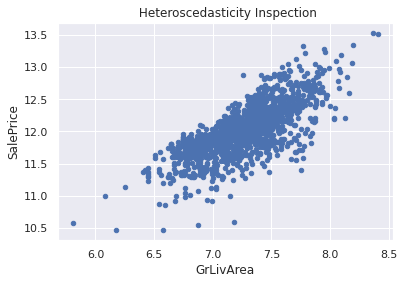

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


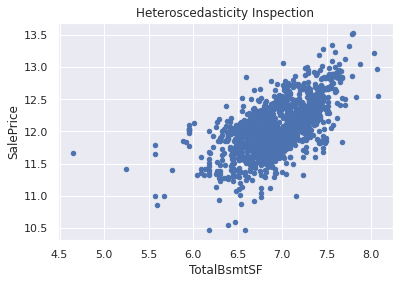

In [43]:
""" Heteroscedasticity Inspection (Train data only) """
#----'SalePrice' and 'GrLivArea'----
#Current scatter plot no conic shape, solved the heteroscedasticity problem.
bivrt_df_scatter('GrLivArea','SalePrice',data = hp_train_data,title = ' Heteroscedasticity Inspection' )
#----'SalePrice' and 'TotalBsmtSF'----
#Can accept even it seem very little conic shape
sp_tlb_df = hp_train_data[hp_train_data['TotalBsmtSF']>0]
bivrt_df_scatter('TotalBsmtSF','SalePrice',data= sp_tlb_df , title = 'Heteroscedasticity Inspection')


In [44]:
""" One Hot Encoded """
#convert categorical variable into dummy ; Only numeric value can be fit into ML or DL model
hp_train_data = pd.get_dummies(hp_train_data)
hp_train_data.shape

(1458, 180)

## Testing data pre-processing

In [45]:
""" Check dataset"""
hp_test_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [46]:
hp_test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [47]:
hp_test_data.shape

(1459, 80)

In [48]:
hp_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [49]:
# Remove unwanted columns, find it in Train processing part
hp_test_data = hp_test_data.drop(Rem_cols_train, axis=1)

In [50]:
""" Imputate Missing Data"""
# Display missing data
total = hp_test_data.isnull().sum().sort_values(ascending=False)
total

MSZoning         4
Utilities        2
BsmtFullBath     2
Functional       2
BsmtUnfSF        1
BsmtFinSF1       1
SaleType         1
TotalBsmtSF      1
Exterior2nd      1
KitchenQual      1
Exterior1st      1
GarageCars       1
GarageArea       1
LandContour      0
YearBuilt        0
RoofMatl         0
LotArea          0
Street           0
LotShape         0
RoofStyle        0
YearRemodAdd     0
OverallQual      0
LotConfig        0
HouseStyle       0
BldgType         0
Condition2       0
Condition1       0
LandSlope        0
Neighborhood     0
SaleCondition    0
ExterQual        0
HalfBath         0
PoolArea         0
OpenPorchSF      0
WoodDeckSF       0
PavedDrive       0
Fireplaces       0
TotRmsAbvGrd     0
KitchenAbvGr     0
BedroomAbvGr     0
FullBath         0
ExterCond        0
GrLivArea        0
2ndFlrSF         0
1stFlrSF         0
Electrical       0
CentralAir       0
HeatingQC        0
Heating          0
Foundation       0
MSSubClass       0
dtype: int64

In [51]:
percent = (hp_test_data.isnull().sum()/hp_test_data.shape[0]).sort_values(ascending=False)
percent

MSZoning         0.002742
Utilities        0.001371
BsmtFullBath     0.001371
Functional       0.001371
BsmtUnfSF        0.000685
BsmtFinSF1       0.000685
SaleType         0.000685
TotalBsmtSF      0.000685
Exterior2nd      0.000685
KitchenQual      0.000685
Exterior1st      0.000685
GarageCars       0.000685
GarageArea       0.000685
LandContour      0.000000
YearBuilt        0.000000
RoofMatl         0.000000
LotArea          0.000000
Street           0.000000
LotShape         0.000000
RoofStyle        0.000000
YearRemodAdd     0.000000
OverallQual      0.000000
LotConfig        0.000000
HouseStyle       0.000000
BldgType         0.000000
Condition2       0.000000
Condition1       0.000000
LandSlope        0.000000
Neighborhood     0.000000
SaleCondition    0.000000
ExterQual        0.000000
HalfBath         0.000000
PoolArea         0.000000
OpenPorchSF      0.000000
WoodDeckSF       0.000000
PavedDrive       0.000000
Fireplaces       0.000000
TotRmsAbvGrd     0.000000
KitchenAbvGr

In [52]:
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percentage'])
missing_data.head(20)

,total,percentage
MSZoning,4,0.002742
Utilities,2,0.001371
BsmtFullBath,2,0.001371
Functional,2,0.001371
BsmtUnfSF,1,0.000685
BsmtFinSF1,1,0.000685
SaleType,1,0.000685
TotalBsmtSF,1,0.000685
Exterior2nd,1,0.000685
KitchenQual,1,0.000685


In [53]:
Miss_cols_test = missing_data[missing_data.total > 0].index
Miss_cols_test

Index(['MSZoning', 'Utilities', 'BsmtFullBath', 'Functional', 'BsmtUnfSF',
       'BsmtFinSF1', 'SaleType', 'TotalBsmtSF', 'Exterior2nd', 'KitchenQual',
       'Exterior1st', 'GarageCars', 'GarageArea'],
      dtype='object')

In [54]:
# Select the columns that are non-number type
Object_cols = hp_test_data[Miss_cols_test].select_dtypes(exclude= [np.number]).columns
Object_cols

Index(['MSZoning', 'Utilities', 'Functional', 'SaleType', 'Exterior2nd',
       'KitchenQual', 'Exterior1st'],
      dtype='object')

In [55]:
# Select the columns that are non-object type
Num_cols = hp_test_data[Miss_cols_test].select_dtypes(exclude=['object']).columns
Num_cols

Index(['BsmtFullBath', 'BsmtUnfSF', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageCars',
       'GarageArea'],
      dtype='object')

In [56]:
# Fill in nan with most common info in specific columns
c = Object_cols[0]
c

'MSZoning'

In [57]:
hp_test_data[Object_cols][c].value_counts()

RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64

In [58]:
hp_test_data[Object_cols][c].value_counts().argmax()

0

In [59]:
hp_test_data[Object_cols][c].value_counts().idxmax()

'RL'

In [60]:
# Fill in nan with most common info in specific columns
for c in Object_cols:
    Fill_data = hp_test_data[Object_cols][c].value_counts().idxmax()
    hp_test_data[c].fillna(Fill_data, inplace = True)

for c in Num_cols:
    hp_test_data[c].fillna(np.mean(hp_test_data[c]), inplace=True)


In [61]:
""" Create the new feature"""
Yrcols = ['YearBuilt', 'YearRemodAdd']
Year = 2019 # used same year in training data
hp_tempData = Year - hp_test_data[Yrcols]
hp_tempData.columns = ['YearBuilt_Reg', 'YearRemodAdd_Reg']
hp_test_data = pd.concat([hp_test_data, hp_tempData], axis=1)
hp_test_data = hp_test_data.drop(Yrcols, axis=1)

In [62]:
""" Label Encoding """
# Label Encoding the ordinal variable [String ---> number]
lbl_encode_train = ['LotShape','LandContour','LandSlope'
                    ,'ExterQual','ExterCond','HeatingQC'
                    ,'KitchenQual','Functional','PavedDrive']

for lbl_c in lbl_encode_train:
    hp_test_data[lbl_c], _ = pd.factorize(hp_test_data[lbl_c])


---GrLivArea (Before)---
Skewness: 1.130402
Kurtosis: 2.920345
---GrLivArea (After)---
Skewness: 0.027624
Kurtosis: 0.113821
---TotalBsmtSF (Before)---
Skewness: 0.813868
Kurtosis: 5.209396
---TotalBsmtSF (After)---
Skewness: -4.830533
Kurtosis: 24.232664


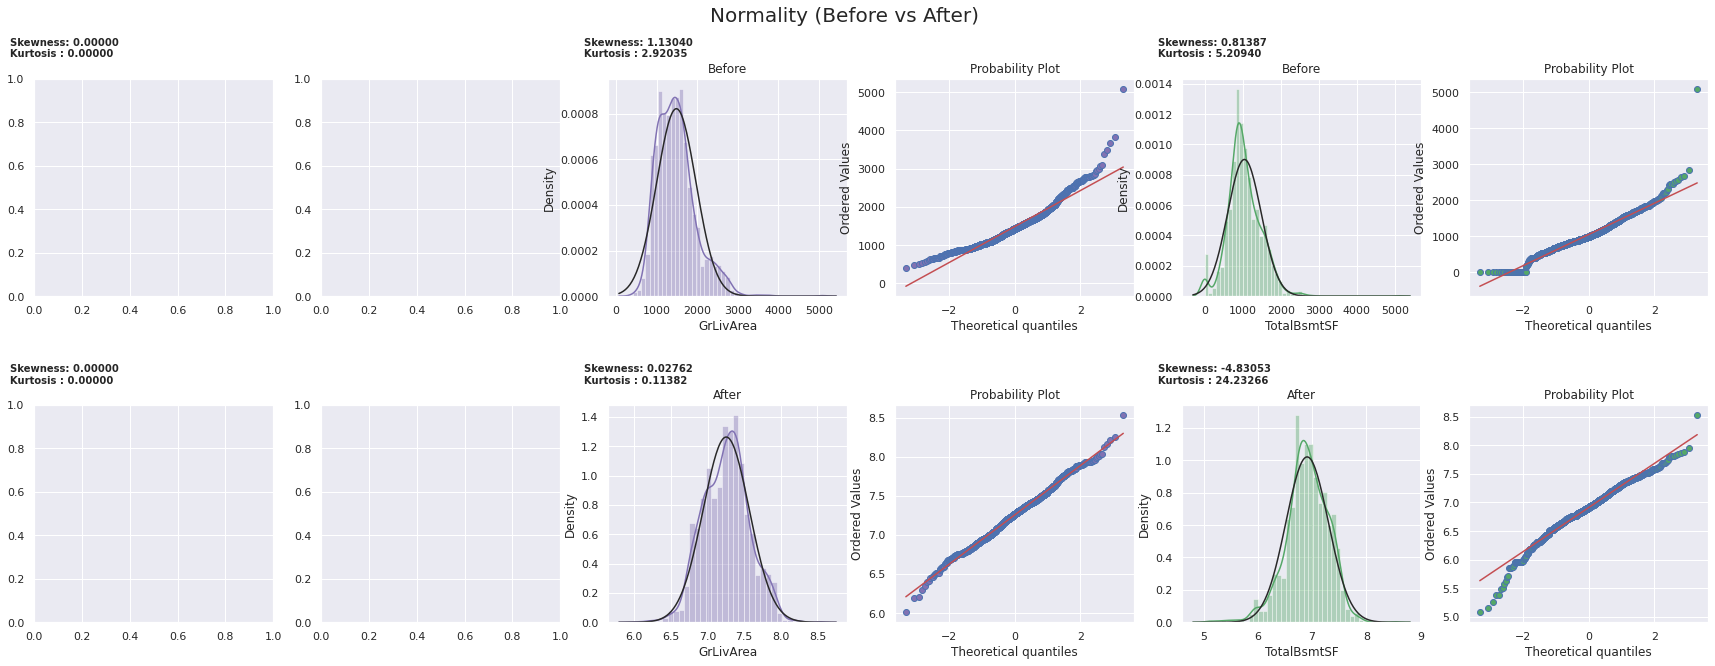

In [63]:
""" Solving Normality To Prevent Heteroscedasticity"""
fig, ax = plt.subplots(figsize=(30, 10), nrows=2, ncols=6)
plt.subplots_adjust(hspace = 0.5)

# Data Log Transformation
hp_test_data, skew_kurt_bf, skew_kurt_af = NormSolver(hp_test_data)

all_skew_kurt = {'sp_bf_skew':0, 'sp_bf_kurt':0}
sp_af = {'sp_af_skew':0, 'sp_af_kurt':0}

all_skew_kurt.update(skew_kurt_bf)
all_skew_kurt.update(sp_af)
all_skew_kurt.update(skew_kurt_af)

ax = ax.flat
for n,ax in enumerate(ax):
    if n%2 == 0:
        get_skew = list(all_skew_kurt.keys())[n]
        get_kurt = list(all_skew_kurt.keys())[n+1]
        ax.text(-0.1, 1.1, 'Skewness: {:.5f}\nKurtosis : {:.5f}'.format(all_skew_kurt[get_skew], all_skew_kurt[get_kurt]), transform=ax.transAxes,
                                                                       size=10, weight='bold')
        
fig.suptitle('Normality (Before vs After)', fontsize=20)
plt.show()

In [64]:
""" One Hot Encoded """
hp_test_data = pd.get_dummies(hp_test_data)
hp_test_data.shape

(1459, 165)

### Columns Filter (Train vs Test Data)

In [65]:
# Get the columns that one dataframe have but other don't
diff_train_cols = hp_train_data[hp_train_data.columns.difference(hp_test_data.columns)].columns

diff_train_cols

Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'Heating_Floor', 'Heating_OthW',
       'HouseStyle_2.5Fin', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'SalePrice', 'Utilities_NoSeWa'],
      dtype='object')

In [66]:
ytrain = hp_train_data.SalePrice
xtrain = hp_train_data.drop(diff_train_cols, axis=1)
xtrain.shape

(1458, 165)

In [67]:
#diff_test_cols is empty for this case. 
#test dataset columns name just matched with train dataset columns name, 
#no extra columns in test dataset
xtest = hp_test_data
xtest.shape

(1459, 165)

In [68]:
class reg_eval:

    @staticmethod
    def adjusted_r2(r2,x,y):
        return 1 - (1-r2)*(len(y)-1)/(len(y)-x.shape[1]-1)

    @staticmethod
    def residual_plot(actual_y,predicted_y):
        res_plot = plt.figure(1)
        res_plot.set_figheight(8)
        res_plot.set_figwidth(12)
        res_plot.axes[0] = sns.residplot(predicted_y, actual_y,
                                  lowess=True,
                                  scatter_kws={'alpha': 0.5},
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
        res_plot.axes[0].set_title('Residuals vs Fitted')
        res_plot.axes[0].set_xlabel('Fitted values')
        res_plot.axes[0].set_ylabel('Residuals')
        plt.show()

    @staticmethod
    def qq_plot(residual_norm):
        QQ = ProbPlot(residual_norm)
        res_plot = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
        res_plot.set_figheight(8)
        res_plot.set_figwidth(12)
        res_plot.axes[0].set_title('Normal Q-Q')
        res_plot.axes[0].set_xlabel('Theoretical Quantiles')
        res_plot.axes[0].set_ylabel('Standardized Residuals')
        plt.show()

In [69]:
XGBRegressor()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

## Model Training

Fitting 15 folds for each of 5 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.7s finished


[10:02:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 All results:

 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=11,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=978, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=True, subsample=1, tree_method='exact',
             va

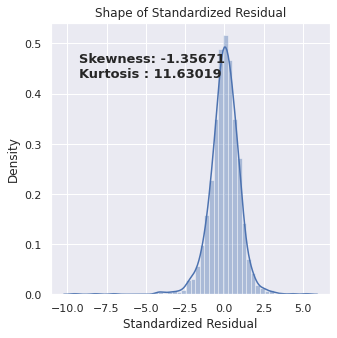

Skewness: -1.356707
Kurtosis: 11.630192


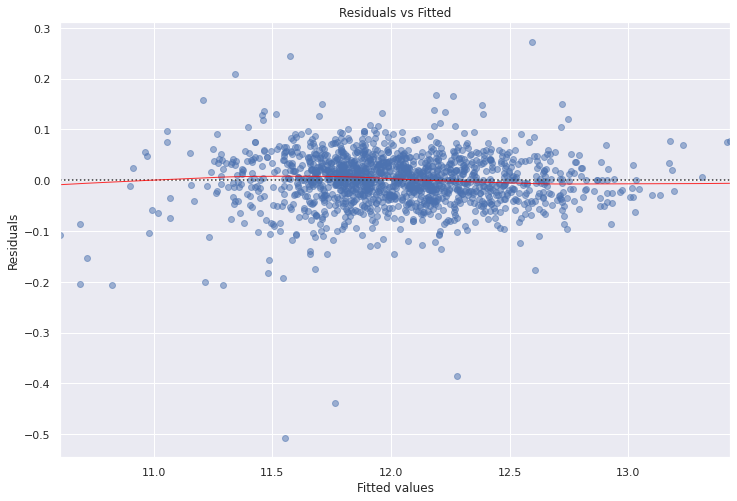

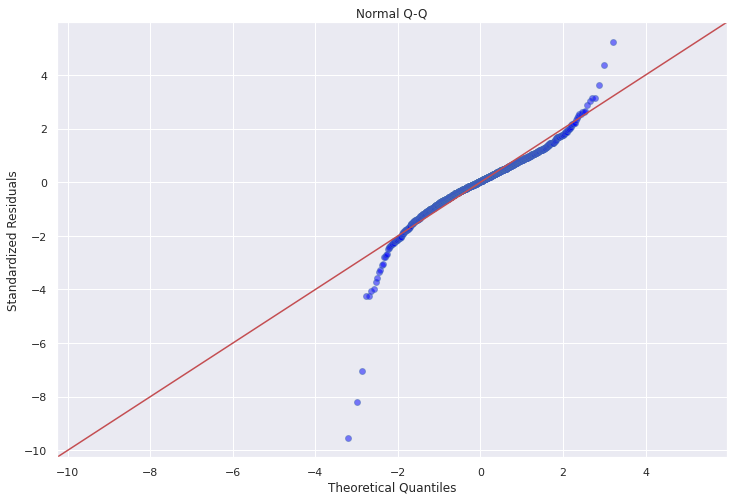

In [70]:
""" XGBoosting """
params = {
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': np.arange(0.3, 0.7, 0.1),
    'colsample_bylevel': np.arange(0.3, 0.7, 0.1),
    'max_depth': range(6, 15),
    'n_estimators': range(100, 1000)
}

folds = 15
param_comb = 5
scoring = {'MSLE': 'neg_mean_squared_log_error', 'r2_score': 'r2'}
kf = KFold(n_splits=folds, random_state=42, shuffle=True)

xgb = XGBRegressor(learning_rate=0.01, gamma=0, subsample=1, objective='reg:squarederror', silent=True, nthread=-1, n_jobs=-1, gpu_id=0)


random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, refit='MSLE', scoring=scoring,
                                   n_jobs=-1, cv=kf.split(xtrain, ytrain), verbose=2, random_state=42, return_train_score=True)


random_search.fit(xtrain, ytrain)

""" Display Result """
print('\n All results:')
random_search.cv_results_
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n RMSLE:')
print(np.sqrt(abs(random_search.best_score_)))
print('\n Best hyperparameters:')
print(random_search.best_params_)

RS_result = pd.DataFrame(random_search.cv_results_)
print('\n')
print('Test r2  : %.5f ' %RS_result.mean_test_r2_score.max())
print('Train r2 : %.5f ' %RS_result.mean_train_r2_score.max())
print('Train adj r2: %.5f ' %reg_eval.adjusted_r2(RS_result.mean_train_r2_score.max(),xtrain,ytrain))
print('\n')
print('Test RMSLE  : %f ' %np.sqrt(abs(RS_result.mean_test_MSLE.max())))
print('Train RMSLE : %f ' %np.sqrt(abs(RS_result.mean_train_MSLE.max())))

predict_ytrain = random_search.predict(xtrain)
residual = ytrain - predict_ytrain
residual_norm_scaler = scale(np.array(residual))

mfig, ax = plt.subplots(figsize=(5,5), nrows=1, ncols=1)
sns.distplot(residual_norm_scaler, ax=ax)
ax.text(0.10, 0.8, "Skewness: {:.5f}\nKurtosis : {:.5f}".format(skew(residual_norm_scaler),kurtosis(residual_norm_scaler)), transform=ax.transAxes,
       size=13, weight='bold')

plt.xlabel('Standardized Residual')
plt.title('Shape of Standardized Residual')
plt.show()
print("Skewness: %f" % skew(residual_norm_scaler))
print("Kurtosis: %f" % kurtosis(residual_norm_scaler))

reg_eval.residual_plot(ytrain, predict_ytrain)
reg_eval.qq_plot(residual_norm_scaler)

### Prediction

In [71]:
pred_xg_test = random_search.predict(xtest)
# Convert back SalePrice from log number by using np.exp
pred_xg_test = np.exp(pred_xg_test)
pred_xg_test

array([122182.38, 161391.23, 190707.98, ..., 161689.03, 118448.3 ,
       236043.84], dtype=float32)

### Submissions for kaggle

In [72]:
submissions = pd.DataFrame({"Id": list(range(1461,len(pred_xg_test)+1461)),
                         "SalePrice": pred_xg_test})
submissions.to_csv("HousePrice_V5.csv", index=False, header=True)

In [73]:
submissions

,Id,SalePrice
0,1461,122182.382812
1,1462,161391.234375
2,1463,190707.984375
3,1464,189424.500000
4,1465,182626.625000
...,...,...
1454,2915,75807.132812
1455,2916,83312.335938
1456,2917,161689.031250
1457,2918,118448.296875
